In [1]:
import os
import sys
import warnings

os.chdir("../..")
sys.path.append("../../")
warnings.filterwarnings("ignore")

# Simulate datasets with multiple lineages

## Introduction

In this example, we will show how to use scDesign3Py to simulate multiple lineages single-cell data.

## Import packages and Read in data

### import pacakges

In [2]:
import anndata as ad
import numpy as np
import scDesign3Py

The R project used is located at /home/ld/anaconda3/envs/pyscdesign/lib/R


### Read in the reference data

The raw data is from the [GEO with ID GSE72859](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE72859), which describes myeloid progenitors from mouse bone marrow. 

We pre-select the top 1000 highly variable genes. To save time, we only use the top 30 genes.

In [3]:
data = ad.read_h5ad("data/MARROW.h5ad")
data = data[:,0:30]
data

View of AnnData object with n_obs × n_vars = 2660 × 30
    obs: 'Seq_batch_ID', 'Amp_batch_ID', 'well_coordinates', 'Plate_ID', 'Pool_barcode', 'Cell_barcode', 'CD34_measurement', 'FcgR3_measurement', 'cluster', 'Size_Factor', 'cell_type', 'Pseudotime', 'State', 'cell_type2', 'ery_meg_lineage_score', 'cell_stemness_score', 'no_expression', 'sizeFactor', 'pseudotime1', 'pseudotime2', 'l1', 'l2'
    var: 'gene_short_name'
    obsm: 'X_umap'

As we can see, this example dataset has two sets of pseudotime, thus two lineages. The variables `pseudotime1` and `pseudotime2` contain the corresponding pseudotime for each cell. The variables `l1` and `l2` indicate whether a particular cell belong to the first and/or second lineages.

In [4]:
data.obs[["pseudotime1","pseudotime2","l1","l2"]].head()

pseudotime1  pseudotime2     l1     l2
W31105     0.950862     0.568357   TRUE   TRUE
W31106     9.168276    -1.000000   TRUE  FALSE
W31107    -1.000000     7.981990  FALSE   TRUE
W31108    11.394132    -1.000000   TRUE  FALSE
W31109    -1.000000     8.080133  FALSE   TRUE

## Simulation

Then, we can use this multiple-lineage dataset to generate new data by setting the parameter `mu_formula` as two smooth terms for each lineage.

In [5]:
test = scDesign3Py.scDesign3(n_cores=3,parallelization="pbmcmapply")
test.set_r_random_seed(123)
simu_res = test.scdesign3(
    anndata=data,
    default_assay_name="counts",
    celltype="cell_type",
    pseudotime=["pseudotime1", "pseudotime2", "l1", "l2"],
    mu_formula="s(pseudotime1, k = 10, by = l1, bs = 'cr') + s(pseudotime2, k = 10, by = l2, bs = 'cr')",
    sigma_formula="1",
    family_use="nb",
    usebam=False,
    corr_formula="1",
    copula="gaussian",
)

R[write to console]: Input Data Construction Start

R[write to console]: Input Data Construction End

R[write to console]: Start Marginal Fitting



  |=======================================================| 100%, Elapsed 00:37


R[write to console]: Marginal Fitting End

R[write to console]: Start Copula Fitting

R[write to console]: Convert Residuals to Multivariate Gaussian



  |=======================================================| 100%, Elapsed 00:03


R[write to console]: Converting End

R[write to console]: Copula group 1 starts

R[write to console]: Copula Fitting End

R[write to console]: Start Parameter Extraction



  |=======================================================| 100%, Elapsed 00:02


R[write to console]: Parameter
Extraction End

R[write to console]: Start Generate New Data

R[write to console]: Use Copula to sample a multivariate quantile matrix

R[write to console]: Sample Copula group 1 starts



  |=======================================================| 100%, Elapsed 00:01


R[write to console]: New Data Generating End



Then we can construct new data using the simulated count matrix.

In [6]:
simu_data = ad.AnnData(X=simu_res["new_count"], obs=simu_res["new_covariate"])
simu_data.layers["log_transformed"] = np.log1p(simu_data.X)
data.layers["log_transformed"] = np.log1p(data.X)

## Visualization

R[write to console]: Warning in (function (A, nv = 5, nu = nv, maxit = 1000, work = nv + 7, reorth = TRUE,  :
R[write to console]: 
 
R[write to console]:  You're computing too large a percentage of total singular values, use a standard svd instead.




    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

R[write to console]: Warning in (function (A, nv = 5, nu = nv, maxit = 1000, work = nv + 7, reorth = TRUE,  :
R[write to console]: 
 
R[write to console]:  You're computing too large a percentage of total singular values, use a standard svd instead.



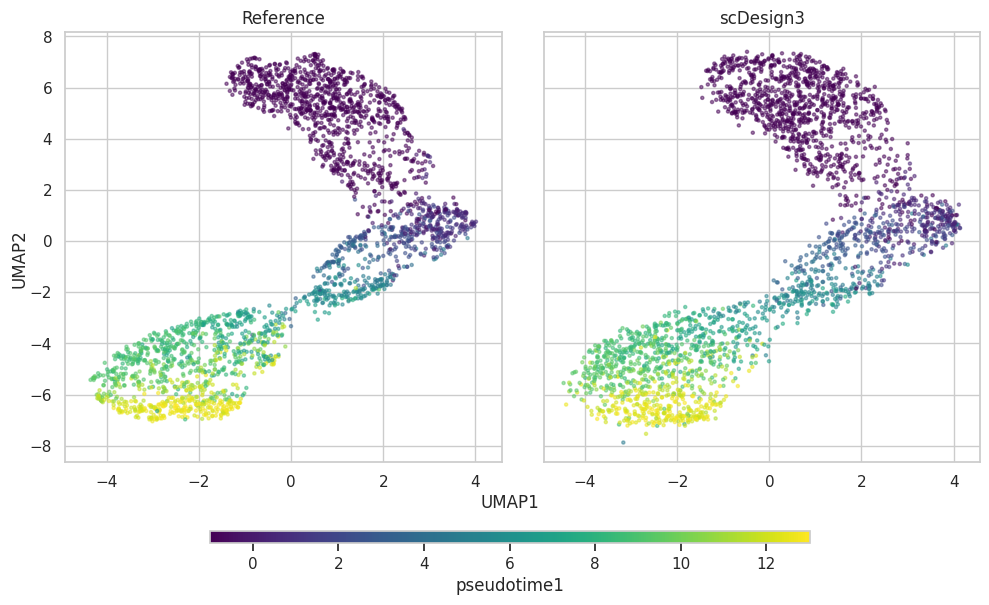

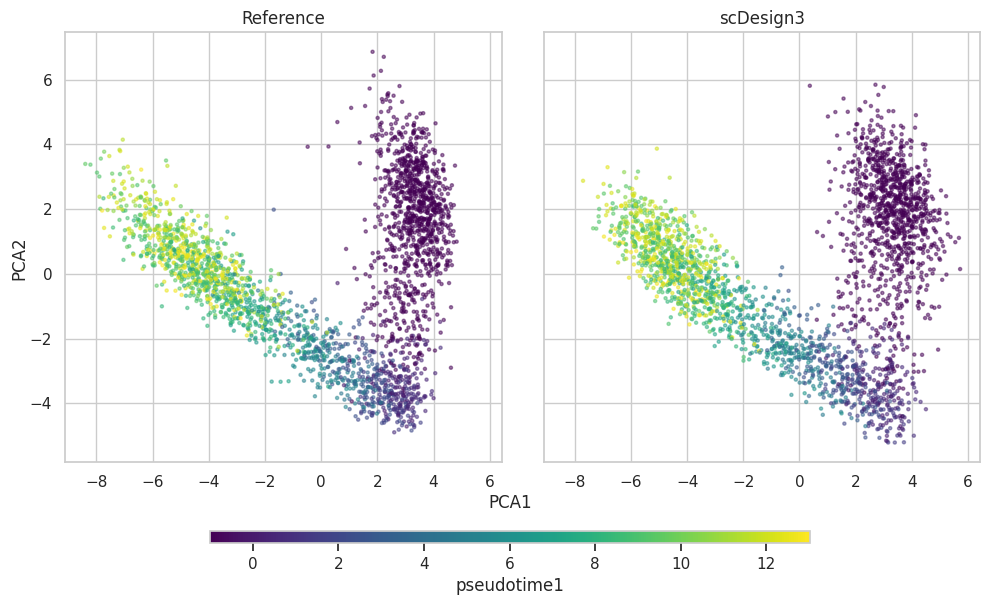

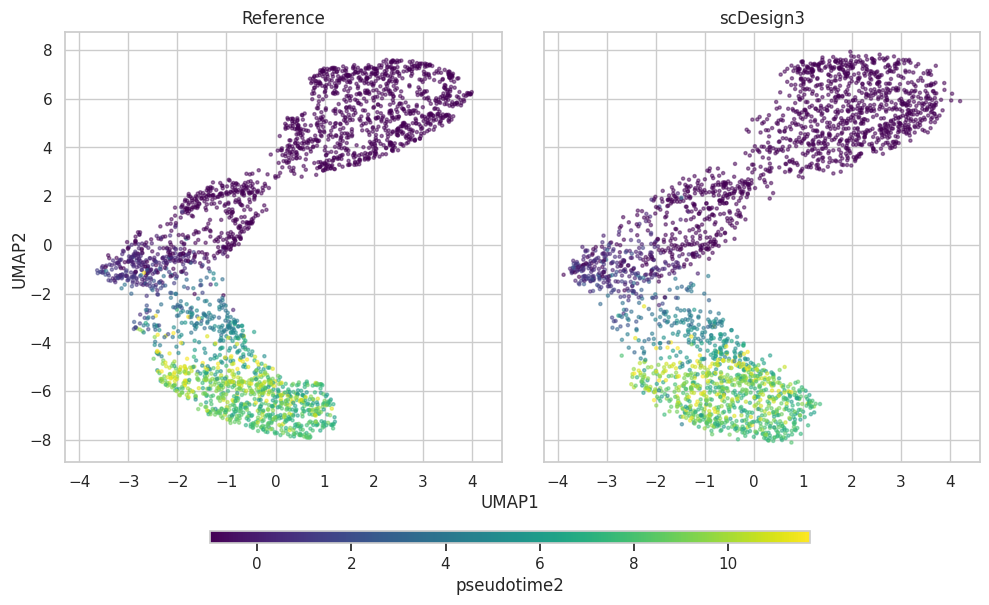

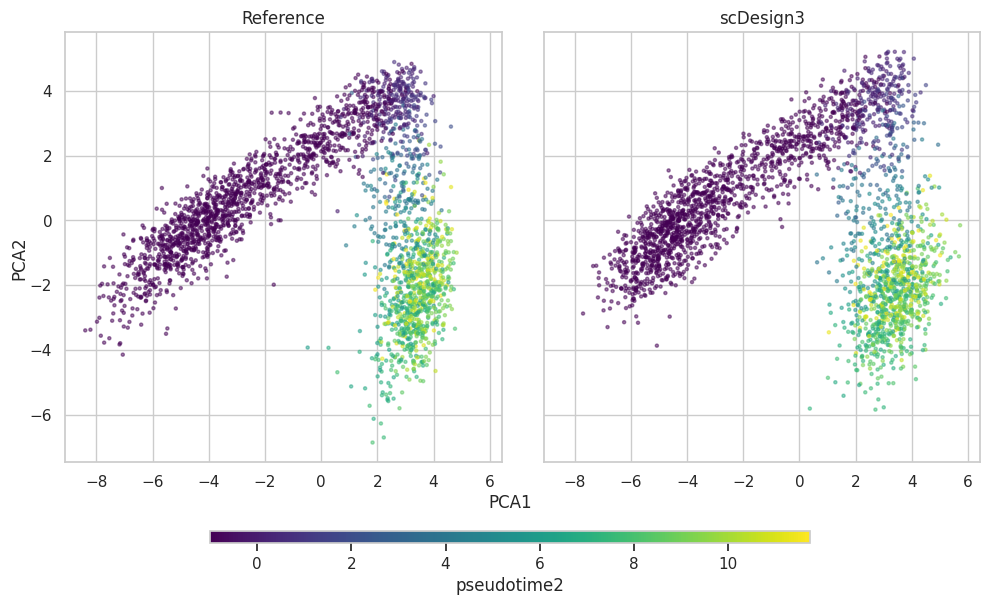

In [7]:
plot1 = scDesign3Py.plot_reduceddim(
    ref_anndata=data,
    anndata_list=simu_data,
    name_list=["Reference", "scDesign3"],
    assay_use="log_transformed",
    if_plot=True,
    color_by="pseudotime1",
    n_pc=20,
    point_size=5,
)
plot2 = scDesign3Py.plot_reduceddim(
    ref_anndata=data,
    anndata_list=simu_data,
    name_list=["Reference", "scDesign3"],
    assay_use="log_transformed",
    if_plot=True,
    color_by="pseudotime2",
    n_pc=20,
    point_size=5,
)

### Pseudotime1

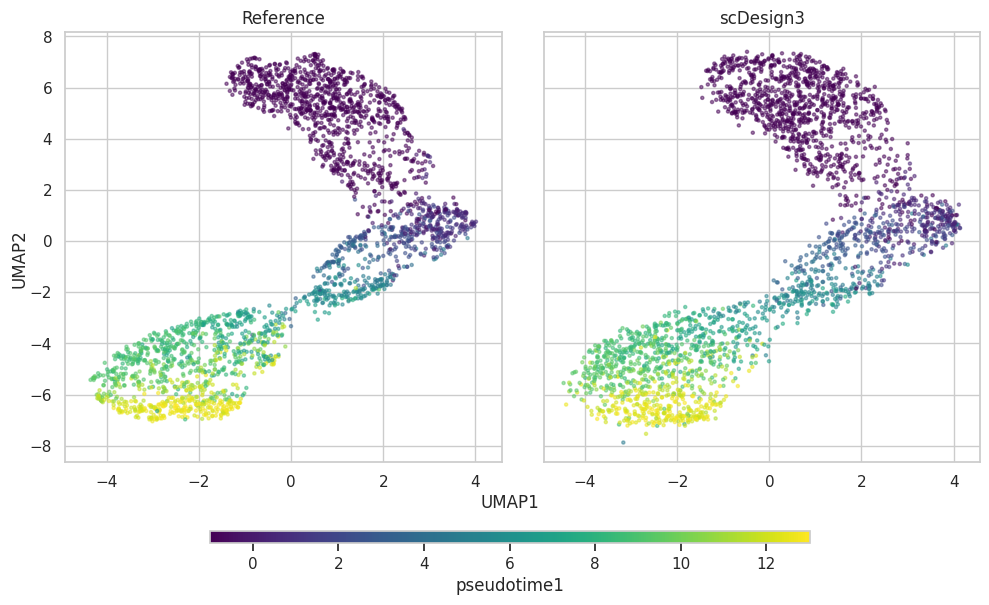

In [8]:
plot1["p_umap"]

### Pseudotime2

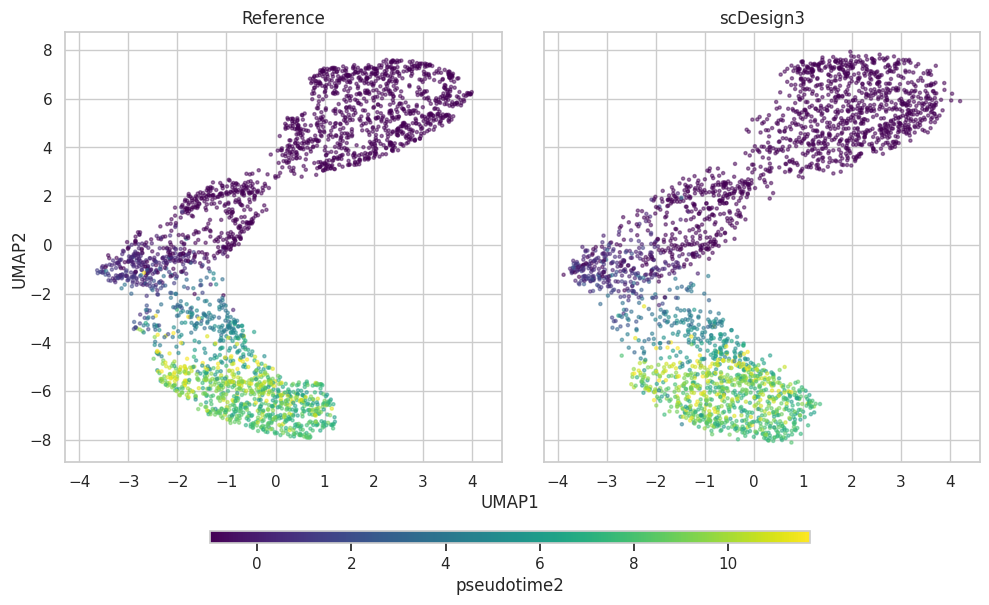

In [9]:
plot2["p_umap"]